In [3]:
import numpy as np
import h5py
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import os
import shutil
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
from torchvision.models import resnet34
from torch.optim import Adam
from torchvision.utils import make_grid
from tqdm import tqdm
from torchviz import make_dot

In [2]:
pip install torchviz


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/EE541_Project/data/cullpdb+profile_6133.npy'
sequence_len = 700
total_features = 57
amino_acid_residues = 21
num_classes = 8

def get_dataset(dataset_path):
  ds = np.load(dataset_path)
  ds = np.reshape(ds, (ds.shape[0], sequence_len, total_features))
  ds_filtered = np.zeros((ds.shape[0], ds.shape[1], amino_acid_residues + num_classes))
  ds_filtered[:, :, 0:amino_acid_residues] = ds[:, :, 35:56]
  ds_filtered[:, :, amino_acid_residues:] = ds[:, :, amino_acid_residues + 1:amino_acid_residues+ 1 + num_classes]
  return ds_filtered

def get_data_labels(Dataset):
    X = Dataset[:, :, 0:amino_acid_residues]
    Y = Dataset[:, :, amino_acid_residues:amino_acid_residues + num_classes]
    mask = (np.sum(Y, axis=-1) != 0)  # Mask to ignore padded positions
    return X, Y, mask

# def shuffle_and_split(Dataset, seed=None):
#     np.random.seed(seed)
#     np.random.shuffle(Dataset)
#     train_split = int(Dataset.shape[0]*0.8)
#     test_val_split = int(Dataset.shape[0]*0.1)
#     Train = Dataset[0:train_split, :, :]
#     Test = Dataset[train_split:train_split+test_val_split, :, :]
#     Validation = Dataset[train_split+test_val_split:, :, :]
#     return Train, Test, Validation


def shuffle_and_split(Dataset, seed=None):
    train_val, test = train_test_split(Dataset, test_size=0.2, random_state=seed)
    train, val = train_test_split(train_val, test_size=0.125, random_state=seed)  # 0.125 * 0.8 = 0.1
    return train, test, val

In [6]:
dataset = get_dataset(dataset_path)
X, y, mask = get_data_labels(dataset)
#D_train, D_test, D_val = shuffle_and_split(dataset, 100)

#X_train, y_train = get_data_labels(D_train)
#X_test, y_test = get_data_labels(D_test)
#X_val, y_val = get_data_labels(D_val)

#print("Dataset Loaded")

In [ ]:
X.shape

(6133, 700, 21)

In [8]:
X_train, X_test, X_val = shuffle_and_split(X, 100)
y_train, y_test, y_val = shuffle_and_split(y, 100)
mask_train, mask_test, mask_val = shuffle_and_split(mask, 100)

In [ ]:
y_train.shape

(4292, 700, 8)

In [9]:
LR = 0.001  # Learning rate
drop_out = 0.3  # Dropout rate
batch_dim = 32  # Batch size
nn_epochs = 25  # Number of epochs
loss_fn = nn.CrossEntropyLoss()  # Cross-entropy loss function for classification

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
mask_train_tensor = torch.tensor(mask_train, dtype=torch.bool)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
mask_test_tensor = torch.tensor(mask_test, dtype=torch.bool)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
mask_val_tensor = torch.tensor(mask_val, dtype=torch.bool)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor, mask_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor, mask_test_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor, mask_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_dim, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_dim, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_dim, shuffle=False)

class SecondaryStructureHybrid(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout):
        super(SecondaryStructureHybrid, self).__init__()

        # CNN for local feature extraction
        self.conv = nn.Conv1d(input_dim, 128, kernel_size=11, padding=5)
        self.bn = nn.BatchNorm1d(128)
        self.dropout_cnn = nn.Dropout(dropout)

        # Bidirectional LSTM for sequence modeling
        self.bilstm = nn.LSTM(128, hidden_dim, batch_first=True, bidirectional=True)

        # Fully connected layer for classification
        self.fc = nn.Linear(2 * hidden_dim, num_classes)

    def forward(self, x):
        # Input shape: (batch_size, sequence_length, input_dim)
        x = x.permute(0, 2, 1)  # Change to (batch_size, input_dim, sequence_length)
        x = F.relu(self.bn(self.conv(x)))
        x = self.dropout_cnn(x)
        x = x.permute(0, 2, 1)  # Back to (batch_size, sequence_length, 128)
        x, _ = self.bilstm(x)  # Output shape: (batch_size, sequence_length, 2 * hidden_dim)
        x = self.fc(x)  # Output shape: (batch_size, sequence_length, num_classes)
        return x

# Instantiate the model
sequence_len = 700  # Example sequence length
amino_acid_residues = 21  # Number of amino acid residues (input channels)
num_classes = 8  # Number of output classes (e.g., Q8 accuracy classification)

model = SecondaryStructureHybrid(input_dim=21, hidden_dim=128, num_classes=8, dropout=0.3)

# Optimizer and Learning Rate
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)

# Print the model summary
print(model)

SecondaryStructureHybrid(
  (conv): Conv1d(21, 128, kernel_size=(11,), stride=(1,), padding=(5,))
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_cnn): Dropout(p=0.3, inplace=False)
  (bilstm): LSTM(128, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=8, bias=True)
)


In [8]:
# Training loop
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

for epoch in range(nn_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_X, batch_y, mask in train_loader:
        optimizer.zero_grad()  # Clear gradients

        # Forward pass
        outputs = model(batch_X)  # Shape: (batch_size, sequence_length, num_classes)
        #print("Outputs shape before reshaping:", outputs.shape)

        # If batch_y is one-hot encoded, convert to class indices
        if batch_y.dim() == 3:  # Check if labels are one-hot
          batch_y = batch_y.argmax(dim=2)  # Shape: (batch_size, sequence_length)

        # Reshape outputs and labels for CrossEntropyLoss
        outputs = outputs.reshape(-1, num_classes)  # Flatten to (batch_size * sequence_length, num_classes)
        batch_y = batch_y.reshape(-1)  # Flatten to (batch_size * sequence_length)
        mask = mask.reshape(-1)  # (batch_size * sequence_length)

        # Apply the mask to exclude padding positions (mask should be 1 for valid, 0 for padding)
        outputs_masked = outputs[mask]  # Select valid positions
        batch_y_masked = batch_y[mask]  # Select valid labels

        #print("Labels shape after reshaping:", batch_y.shape)
        #print("Outputs shape after reshaping:", outputs.shape)

        assert outputs.shape[0] == batch_y.shape[0], "Mismatch in output and label batch sizes"
        # Compute loss
        loss = loss_fn(outputs_masked, batch_y_masked)
        train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Compute accuracy

        #mask = (batch_y != padding_label)  # Mask to exclude padding
        _, predicted = torch.max(outputs_masked, dim=1)  # Predicted class indices
        train_correct += (predicted == batch_y_masked).sum().item()
        train_total += mask.sum().item() # Count valid residues
    # Calculate epoch-level metrics
    train_accuracy = 100 * train_correct / train_total
    train_loss /= len(train_loader)

    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch_X, batch_y, mask in val_loader:
            outputs = model(batch_X)
            if batch_y.dim() == 3:  # Check if labels are one-hot
              batch_y = batch_y.argmax(dim=2)
            # Reshape for loss computation
            outputs = outputs.reshape(-1, num_classes)
            batch_y = batch_y.reshape(-1)
            mask = mask.reshape(-1)

            # Apply the mask to exclude padding positions
            outputs_masked = outputs[mask]
            batch_y_masked = batch_y[mask]

            loss = loss_fn(outputs_masked, batch_y_masked)
            val_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs_masked, dim=1)
            val_correct += (predicted == batch_y_masked).sum().item()
            val_total += mask.sum().item()  # Count valid residues

    # Calculate validation metrics
    val_accuracy = 100 * val_correct / val_total
    val_loss /= len(val_loader)

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{nn_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch [1/25]
Train Loss: 1.1440, Train Accuracy: 58.10%
Val Loss: 0.9769, Val Accuracy: 64.67%
Epoch [2/25]
Train Loss: 0.9526, Train Accuracy: 65.69%
Val Loss: 0.9216, Val Accuracy: 66.42%
Epoch [3/25]
Train Loss: 0.9106, Train Accuracy: 67.12%
Val Loss: 0.9043, Val Accuracy: 67.06%
Epoch [4/25]
Train Loss: 0.8905, Train Accuracy: 67.78%
Val Loss: 0.8782, Val Accuracy: 67.88%
Epoch [5/25]
Train Loss: 0.8789, Train Accuracy: 68.28%
Val Loss: 0.8661, Val Accuracy: 68.38%
Epoch [6/25]
Train Loss: 0.8601, Train Accuracy: 68.82%
Val Loss: 0.8598, Val Accuracy: 68.64%
Epoch [7/25]
Train Loss: 0.8473, Train Accuracy: 69.27%
Val Loss: 0.8460, Val Accuracy: 69.11%
Epoch [8/25]
Train Loss: 0.8402, Train Accuracy: 69.46%
Val Loss: 0.8653, Val Accuracy: 68.31%
Epoch [9/25]
Train Loss: 0.8334, Train Accuracy: 69.74%
Val Loss: 0.8345, Val Accuracy: 69.39%
Epoch [10/25]
Train Loss: 0.8295, Train Accuracy: 69.89%
Val Loss: 0.8371, Val Accuracy: 69.41%
Epoch [11/25]
Train Loss: 0.8202, Train Accuracy:

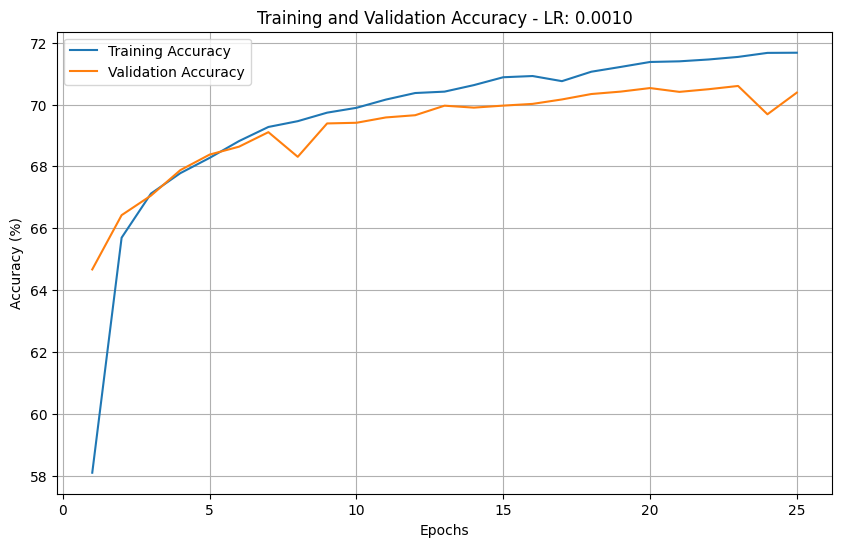

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, nn_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, nn_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title(f'Training and Validation Accuracy - LR: {LR:.4f}')
plt.legend()
plt.grid()
plt.show()

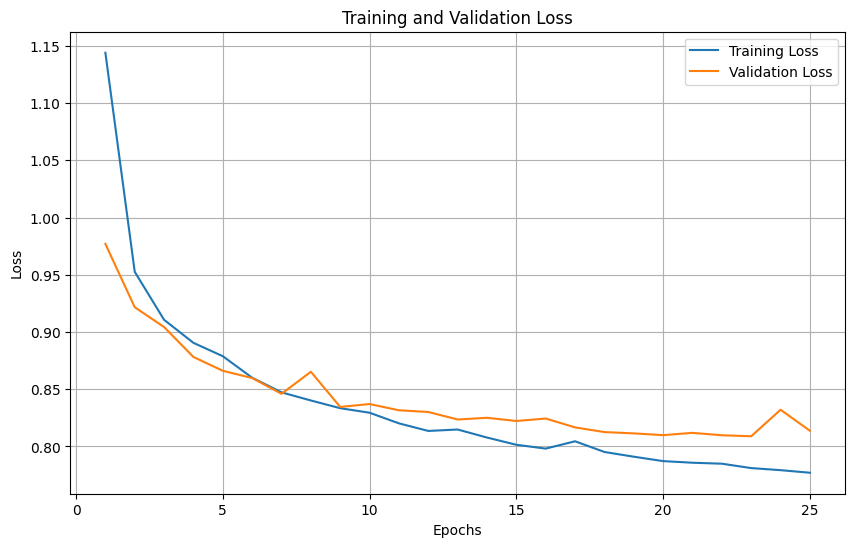

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, nn_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, nn_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [11]:
def predict(model, data_loader, num_classes, sequence_len=700):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []  # To store all predictions
    all_labels = []  # To store all ground truth labels
    all_valid_positions = []  # To store all masks for valid positions

    with torch.no_grad():  # Disable gradient computation
        for batch_X, batch_y, mask in data_loader:
            # Forward pass
            outputs = model(batch_X)  # Shape: (batch_size, sequence_len, num_classes)

            # If labels are one-hot encoded, convert to class indices
            if batch_y.dim() == 3:  # Check if labels are one-hot encoded
                batch_y = batch_y.argmax(dim=2)  # Shape: (batch_size, sequence_len)

            # Flatten outputs, labels, and masks
            outputs = outputs.reshape(-1, num_classes)  # Shape: (batch_size * sequence_len, num_classes)
            batch_y = batch_y.reshape(-1)  # Shape: (batch_size * sequence_len)
            mask = mask.reshape(-1)  # Shape: (batch_size * sequence_len)

            # Apply the mask to filter valid positions
            outputs_masked = outputs[mask]  # Select valid positions
            batch_y_masked = batch_y[mask]  # Select valid labels
            _, predicted_masked = torch.max(outputs_masked, dim=1)  # Predicted classes for valid positions

            # Reshape predictions back to original sequence structure
            predicted = torch.zeros(batch_X.size(0) * sequence_len, dtype=torch.long, device=outputs.device)
            predicted[mask] = predicted_masked  # Fill valid predictions into the original shape
            predicted = predicted.reshape(batch_X.size(0), sequence_len)  # Shape: (batch_size, sequence_len)

            # Append predictions, ground truth labels, and mask for valid positions
            all_predictions.append(predicted.cpu().numpy())  # Convert predictions to numpy
            all_labels.append(batch_y.reshape(batch_X.size(0), sequence_len).cpu().numpy())  # Convert labels to numpy
            all_valid_positions.append(mask.reshape(batch_X.size(0), sequence_len).cpu().numpy())  # Convert mask to numpy

    # Concatenate results across all batches
    all_predictions = np.concatenate(all_predictions, axis=0)  # Shape: (num_samples, sequence_len)
    all_labels = np.concatenate(all_labels, axis=0)  # Shape: (num_samples, sequence_len)
    all_valid_positions = np.concatenate(all_valid_positions, axis=0)  # Shape: (num_samples, sequence_len)

    # Calculate Q8 accuracy
    valid_predictions = all_predictions[all_valid_positions]  # Predicted classes for valid positions
    valid_labels = all_labels[all_valid_positions]  # True labels for valid positions
    correct = (valid_predictions == valid_labels).sum()
    total = valid_labels.size
    q8_accuracy = 100 * correct / total if total > 0 else 0.0

    return all_predictions, all_valid_positions, q8_accuracy

In [12]:
all_predictions, all_valid_positions, q8_accuracy = predict(model, test_loader, num_classes,sequence_len=700)
print(f"Test Accuracy: {q8_accuracy:.2f}%")

Test Accuracy: 70.65%


In [11]:
#Generating a graph for the visualization
model = SecondaryStructureHybrid(input_dim=21, hidden_dim=128, num_classes=num_classes, dropout=0.3)
dummy_input = torch.randn(4, sequence_len, 21)
output = model(dummy_input)
make_dot(output, params=dict(model.named_parameters())).render("/content/drive/MyDrive/Colab Notebooks/EE541_Project/cnn_bilstm_architecture", format="png")

'/content/drive/MyDrive/Colab Notebooks/EE541_Project/cnn_bilstm_architecture.png'